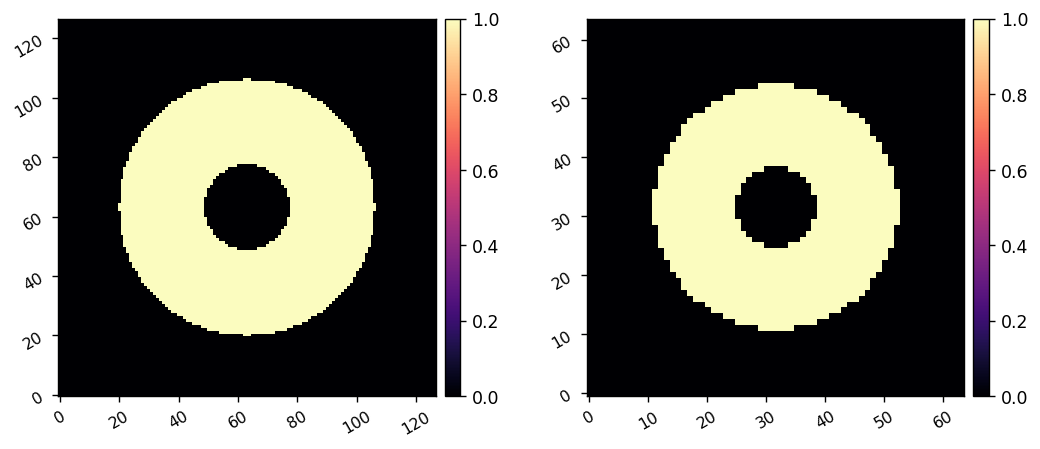

In [18]:
import numpy as np
import astropy.io.fits as fits
import astropy.units as u
from IPython.display import clear_output
import time

from scipy.ndimage import rotate
from scipy.interpolate import RegularGridInterpolator
import h5py
import os
from pathlib import Path

import misc
from matplotlib.patches import Circle
from importlib import reload
reload(misc)

# data_dir = Path('C:/Users/Kian/Documents/data-files/disk-processing')
# data_dir = Path('/users/kianmilani/Documents/data-files/disk-processing')
data_dir = Path('/groups/douglase/kians-data-files/disk-processing')

wavelength_c = 575e-9*u.m
D = 2.3631*u.m
mas_per_lamD = (wavelength_c/D*u.radian).to(u.mas)

# define desired PSF dimensions and pixelscale in units of lambda/D
npsf=64
psf_pixelscale = 13e-6
psf_pixelscale_m = 13e-6*u.m/u.pix
psf_pixelscale_lamD = 500/575 * 1/2
psf_pixelscale_mas = psf_pixelscale_lamD*mas_per_lamD/u.pix

polaxis = 10

ndisk = 127
disk_pixelscale_mas = 10.5*u.mas/u.pix
disk_pixelscale_lamD = (disk_pixelscale_mas/mas_per_lamD).value

band1_wavelength = 575e-9*u.m
iwa_band1 = 3
owa_band1 = 9

iwa = iwa_band1 * wavelength_c/band1_wavelength
owa = owa_band1 * wavelength_c/band1_wavelength

iwa_mas = iwa*mas_per_lamD
owa_mas = owa*mas_per_lamD

x,y = np.meshgrid(np.arange(-ndisk/2,ndisk/2) + 1/2, np.arange(-ndisk/2,ndisk/2)+1/2 )
r = np.sqrt(x**2 + y**2)*disk_pixelscale_lamD
disk_mask = np.zeros((ndisk,ndisk))
disk_mask[((r>iwa)*(r<owa))] = 1

x,y = np.meshgrid(np.arange(-npsf/2,npsf/2) + 1/2, np.arange(-npsf/2,npsf/2)+1/2 )
r = np.sqrt(x**2 + y**2)*psf_pixelscale_lamD
sim_mask = np.zeros((npsf,npsf))
sim_mask[((r>iwa)*(r<owa))] = 1

misc.myimshow2(disk_mask, sim_mask)

In [2]:
fov_owa = owa_mas
fov_im = psf_pixelscale_mas * 64/2

print(fov_owa, fov_im)

451.7034286863541 mas 698.2854936214169 mas / pix


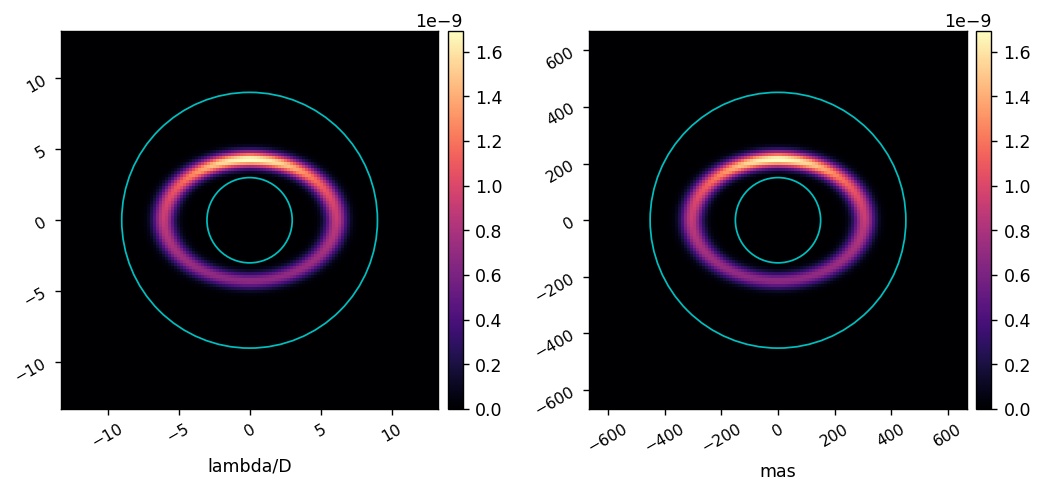

In [3]:
disk_fpath = data_dir/'disks'/'Debes_Models_07_2022'/'ring_inc45_r0.30.fits'

disk = fits.getdata(disk_fpath)
disk = misc.pad_or_crop(disk, ndisk)
disk_hdr = fits.getheader(disk_fpath)

patches1 = [Circle((0, 0), iwa.value, color='c', fill=False), Circle((0, 0), owa.value, color='c', fill=False)]
patches2 = [Circle((0, 0), iwa_mas.value, color='c', fill=False), Circle((0, 0), owa_mas.value, color='c', fill=False)]
misc.myimshow2(disk, disk, lognorm1=False, lognorm2=False, 
               pxscl1=disk_pixelscale_lamD, pxscl2=disk_pixelscale_mas, 
               patches1=patches1, patches2=patches2 )


# Do the matrix multiplication

In [4]:
ipsf_fpath = data_dir/'ipsfs'/'hlc_band1_ipsfs_20221006.hdf5'

f = h5py.File(ipsf_fpath, 'r')
ipsf_matrix = np.array(f['ipsf_matrix'])
f.close()

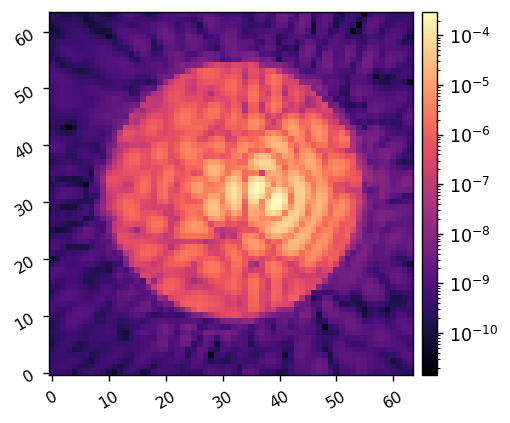

In [5]:
for ipsf in ipsf_matrix.T[ipsf_matrix.shape[1]//2:]:
    try:
        misc.myimshow(ipsf.reshape(npsf,npsf), lognorm=True)
        clear_output(wait=True)
        time.sleep(0.1)
    except KeyboardInterrupt: 
        break

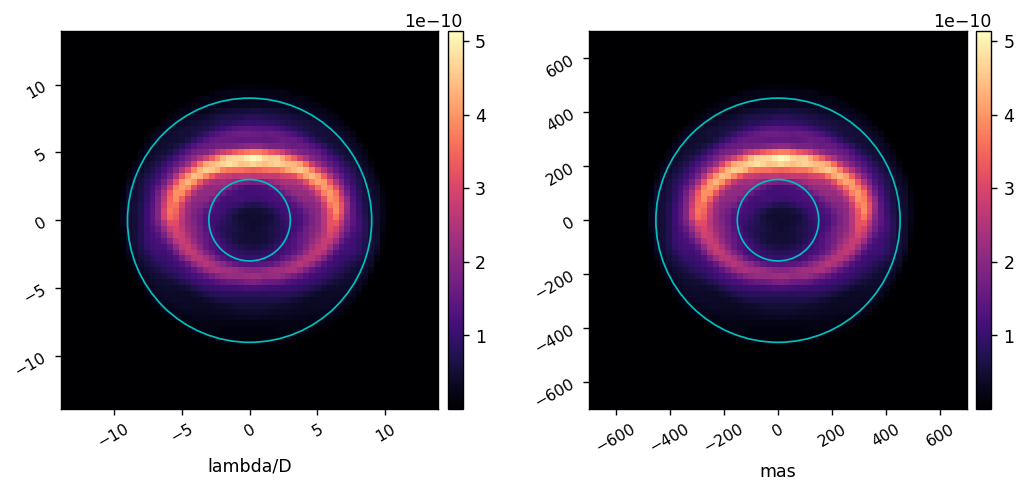

In [6]:
disk_sim = np.reshape(ipsf_matrix.dot(disk.flatten()), (npsf,npsf))

patches1 = [Circle((0, 0), iwa.value, color='c', fill=False), Circle((0, 0), owa.value, color='c', fill=False)]
patches2 = [Circle((0, 0), iwa_mas.value, color='c', fill=False), Circle((0, 0), owa_mas.value, color='c', fill=False)]
misc.myimshow2(disk_sim, disk_sim, 
               pxscl1=psf_pixelscale_lamD, pxscl2=psf_pixelscale_mas, 
               patches1=patches1, patches2=patches2 )

# Point source simulation

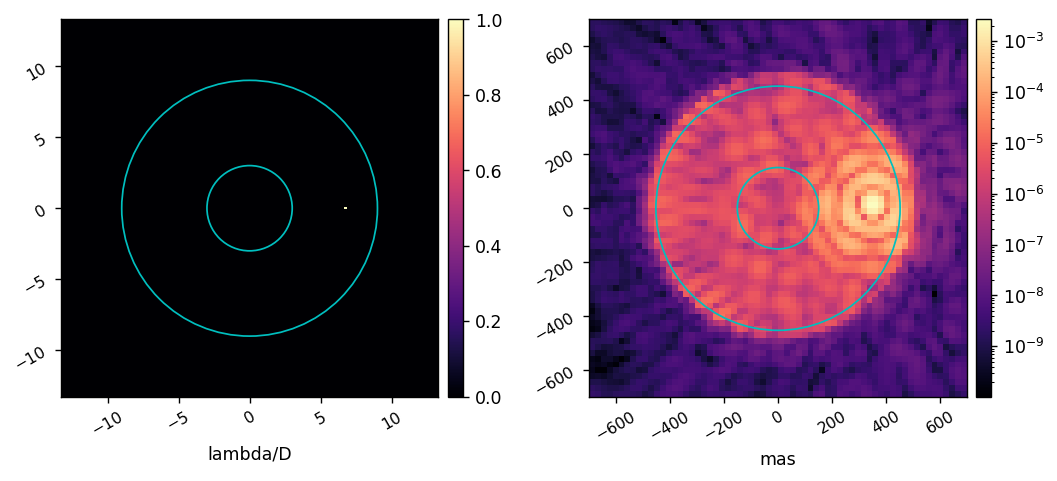

1.0 0.04695884894952636 0.04695884894952636


In [27]:
disk = np.zeros((ndisk,ndisk))
disk[ndisk//2, 3*ndisk//4] = 1

disk_sim = np.reshape(ipsf_matrix.dot(disk.flatten()), (npsf,npsf)) / (psf_pixelscale_lamD/disk_pixelscale_lamD)**2

patches1 = [Circle((0, 0), iwa.value, color='c', fill=False), Circle((0, 0), owa.value, color='c', fill=False)]
patches2 = [Circle((0, 0), iwa_mas.value, color='c', fill=False), Circle((0, 0), owa_mas.value, color='c', fill=False)]
misc.myimshow2(disk, disk_sim, 
               lognorm2=True,
               pxscl1=disk_pixelscale_lamD, pxscl2=psf_pixelscale_mas, 
               patches1=patches1, patches2=patches2 )

# Throughput analysis
disk_sum = (disk*disk_mask).sum()
sim_sum = (disk_sim*sim_mask).sum()
print(disk_sum, sim_sum, sim_sum/disk_sum)

# Extended Source Simulation

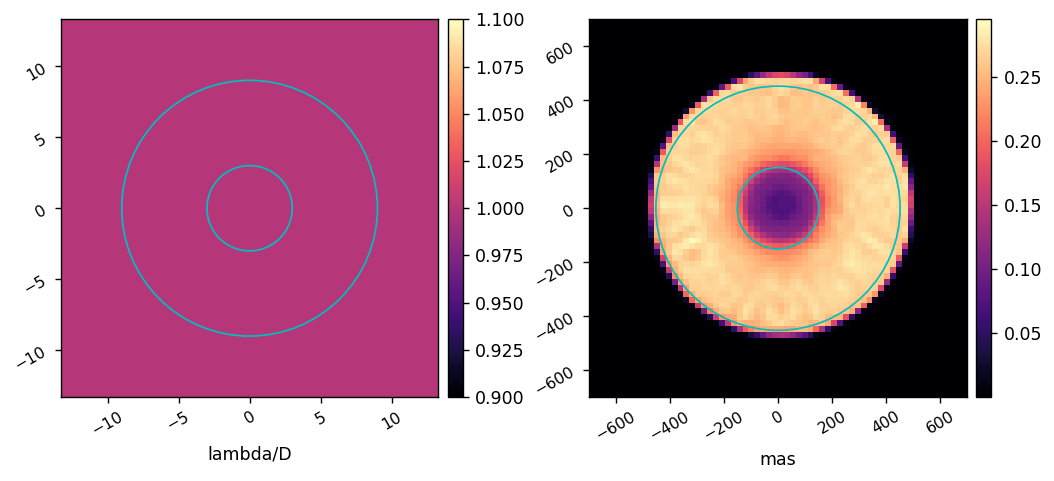

5156.0 311.5275982552289 0.06042040307510258


In [28]:
disk = np.ones((ndisk,ndisk))

disk_sim = np.reshape(ipsf_matrix.dot(disk.flatten()), (npsf,npsf)) / (psf_pixelscale_lamD/disk_pixelscale_lamD)**2

patches1 = [Circle((0, 0), iwa.value, color='c', fill=False), Circle((0, 0), owa.value, color='c', fill=False)]
patches2 = [Circle((0, 0), iwa_mas.value, color='c', fill=False), Circle((0, 0), owa_mas.value, color='c', fill=False)]
misc.myimshow2(disk, disk_sim, 
               pxscl1=disk_pixelscale_lamD, pxscl2=psf_pixelscale_mas, 
               patches1=patches1, patches2=patches2 )

# Throughput analysis
disk_sum = (disk*disk_mask).sum()
sim_sum = (disk_sim*sim_mask).sum()
print(disk_sum, sim_sum, sim_sum/disk_sum)